In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 126 GB / available: 112 GB / percent used: 10.4 %


In [2]:
# Define period
period = slice('1981','2014')

# Define zone
latlim=(10,50)
lonlim=(60,110)

# Variable
var = 'pr'
table = u.get_table(var)
label, units, cmap, levels = u.get_var_infos('pr')

# Load obs
## APHRODITE http://aphrodite.st.hirosaki-u.ac.jp/download/data/search/  
http://aphrodite.st.hirosaki-u.ac.jp/download/
V1101 et V1101EX_R1 domain MA

http://localhost:7227/notebooks/notebooks/CICLAD/Himalaya/CMIP6_IPSL_bias/Precipitation.ipynb

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


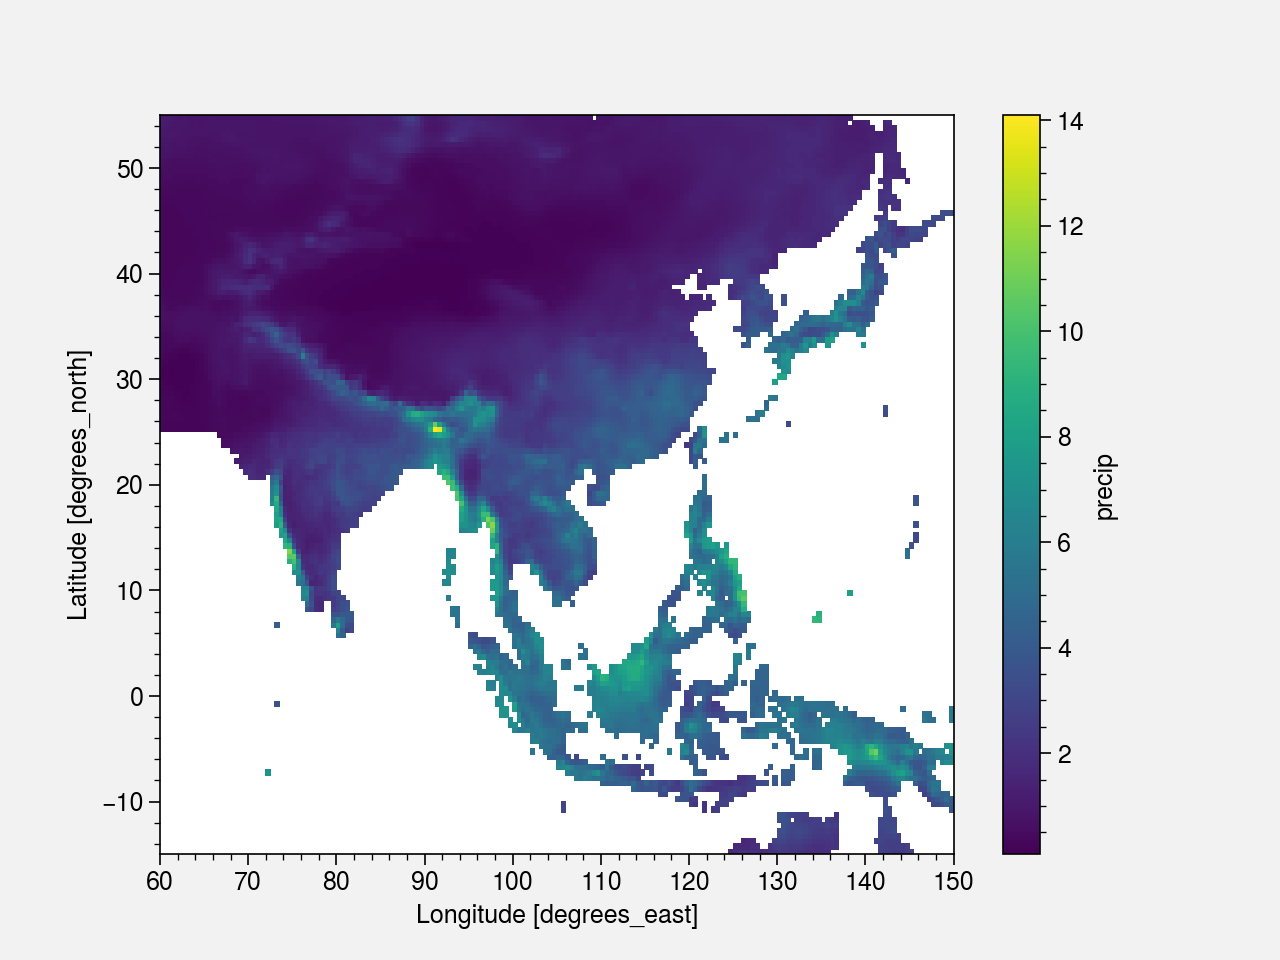

In [3]:
obs_longname = 'APHRODITE V1101 (0.5°)'
obs_name = 'APHRODITE'

obs_V1101 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101.*.nc', combine='by_coords'
).precip
obs_V1101_EXR1 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101_EXR1.*.nc', combine='by_coords'
).precip

obs_V1101 = obs_V1101.rename({'longitude': 'lon', 'latitude': 'lat'})
obs = xr.combine_nested([obs_V1101, obs_V1101_EXR1], concat_dim='time')
# Daily donc pas besoin de faire la clim en prenant en compte le nb de jours dans le mois
obs_clim = obs.sel(time=period).mean('time')
obs_clim.plot()

# Load model data
http://localhost:7227/notebooks/notebooks/CICLAD/Himalaya/ta-global_multimodel/list_models.ipynb


In [65]:
# Because obs are not global (https://github.com/JiaweiZhuang/xESMF/issues/15)
import scipy
def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

# list_models = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CAS-ESM2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CIESM', 'CanESM5', 'E3SM-1-0', 'E3SM-1-1', 'E3SM-1-1-ECA', 'EC-Earth3-Veg', 'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'MCM-UA-1-0', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorCPM1', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON']
list_models = ['BCC-CSM2-MR', 'BCC-ESM1', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CanESM5', 'EC-Earth3-Veg', 'ACCESS-ESM1-5', 'GFDL-CM4', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorCPM1', 'NorESM2-LM', 'SAM0-UNICON']
realization = 'r1i1p1f1'

bias = []
bias_relative = []

for model in list_models:
    print(model)
    institute, grid = u.select_model(model, var)
    
    da = xr.open_mfdataset(
        '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', combine='by_coords'
    ).sel(time=period)[var]
    
    model_clim = u.clim(da) * 86400
    
    
    if model in ['MCM-UA-1-0']:
        model_clim = model_clim.rename({'longitude': 'lon', 'latitude': 'lat'})
        
    # Regrid towards model
    regridder = xe.Regridder(obs_clim, model_clim, 'bilinear', periodic=False, reuse_weights=True)
    regridder = add_matrix_NaNs(regridder)
    obs_clim_regrid = regridder(obs_clim)
    
    bias.append(model_clim - obs_clim_regrid)
    bias_relative.append((model_clim - obs_clim_regrid)/obs_clim_regrid*100)

BCC-CSM2-MR
Reuse existing file: bilinear_140x180_160x320.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


BCC-ESM1
Reuse existing file: bilinear_140x180_64x128.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CESM2
Reuse existing file: bilinear_140x180_192x288.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/conventions.py:487: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CESM2-FV2


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/conventions.py:487: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Reuse existing file: bilinear_140x180_96x144.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CESM2-WACCM
Reuse existing file: bilinear_140x180_192x288.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/conventions.py:487: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CESM2-WACCM-FV2


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/conventions.py:487: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Reuse existing file: bilinear_140x180_96x144.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CanESM5
Reuse existing file: bilinear_140x180_64x128.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EC-Earth3-Veg
Reuse existing file: bilinear_140x180_256x512.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


ACCESS-ESM1-5
Reuse existing file: bilinear_140x180_145x192.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


GFDL-CM4
Reuse existing file: bilinear_140x180_180x288.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


GISS-E2-1-G
Reuse existing file: bilinear_140x180_90x144.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


GISS-E2-1-G-CC
Reuse existing file: bilinear_140x180_90x144.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


GISS-E2-1-H
Reuse existing file: bilinear_140x180_90x144.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


IPSL-CM6A-LR
Reuse existing file: bilinear_140x180_143x144.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


MIROC6
Reuse existing file: bilinear_140x180_128x256.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


MPI-ESM1-2-HR
Reuse existing file: bilinear_140x180_192x384.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


MPI-ESM1-2-LR
Reuse existing file: bilinear_140x180_96x192.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


MRI-ESM2-0
Reuse existing file: bilinear_140x180_160x320.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


NorCPM1
Reuse existing file: bilinear_140x180_142x144.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


NorESM2-LM
Reuse existing file: bilinear_140x180_96x144.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


SAM0-UNICON
Reuse existing file: bilinear_140x180_192x288.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: 

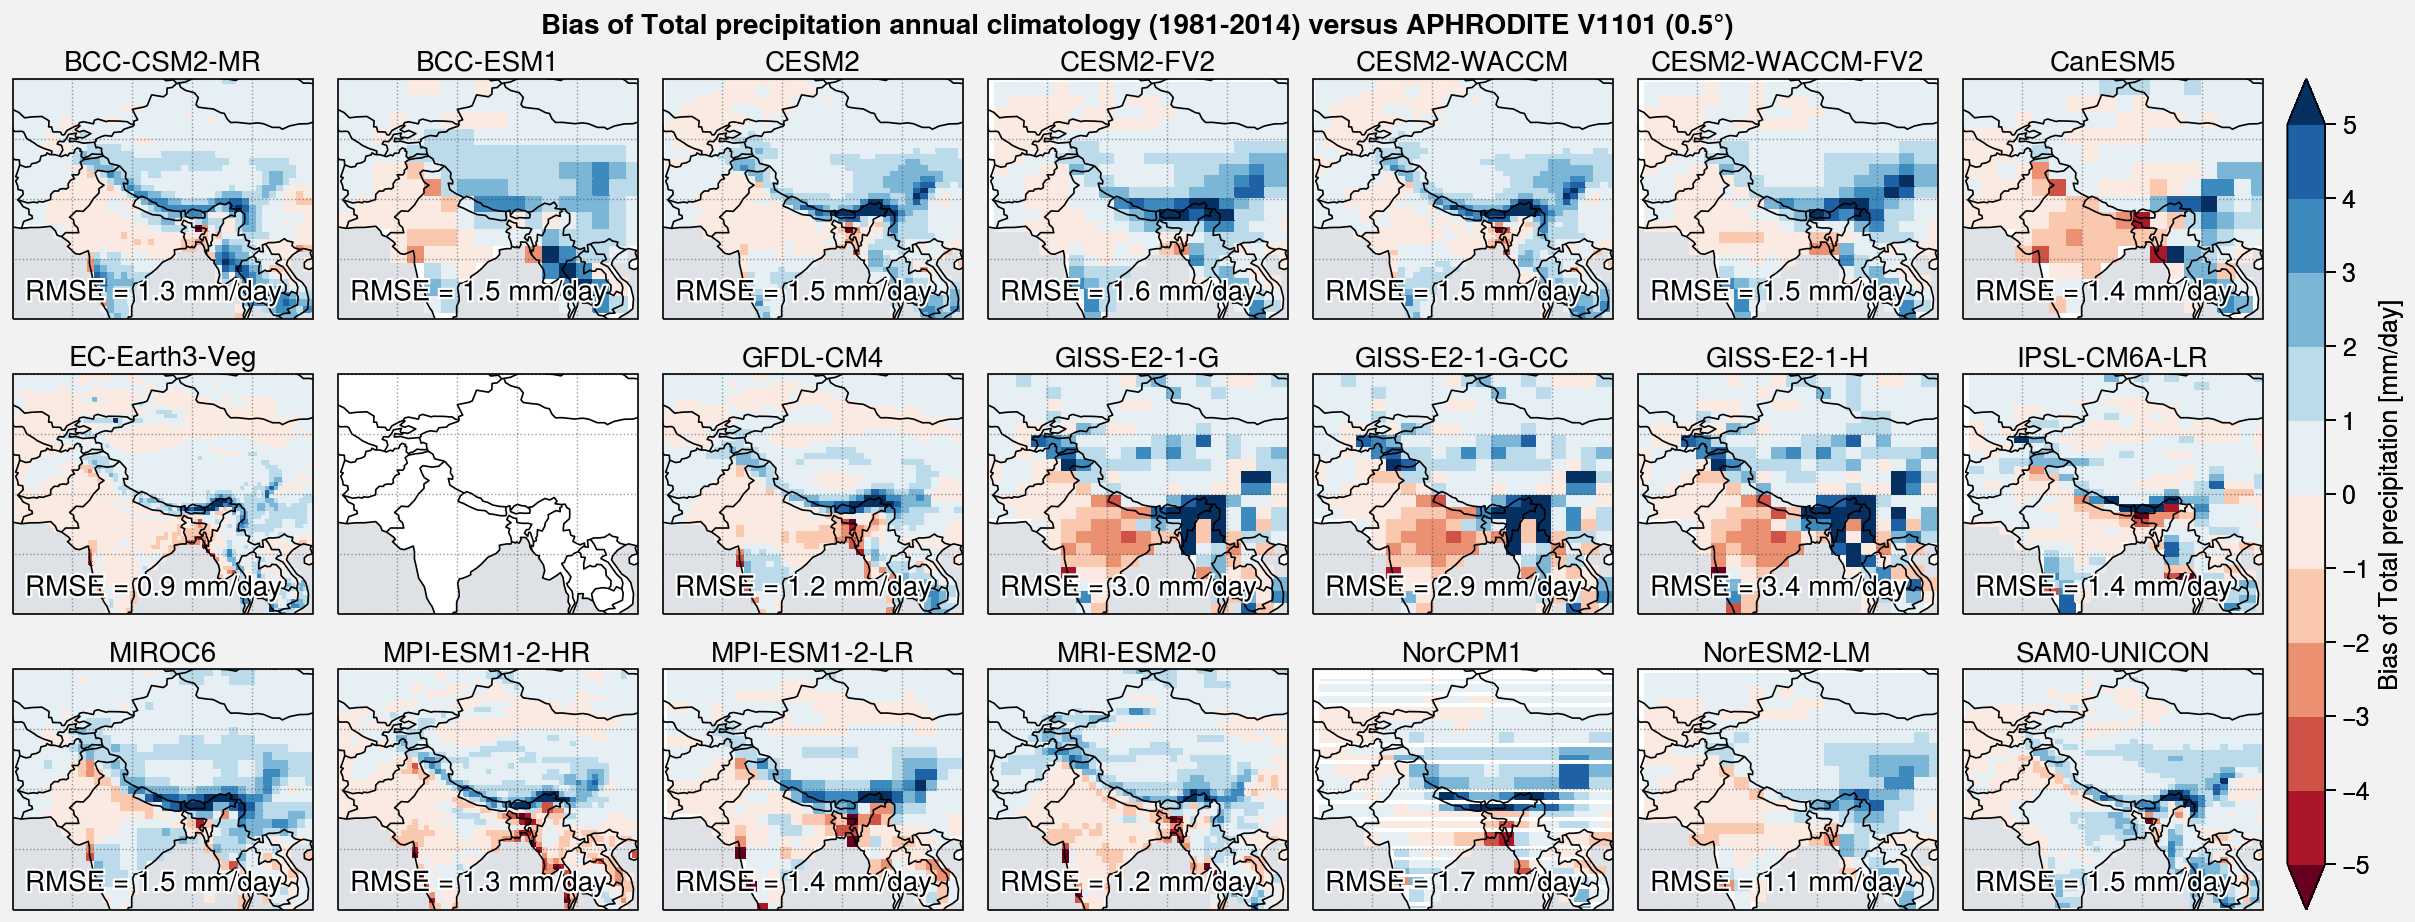

In [67]:
cmap_bias = 'RdBu'
levels_bias = plot.arange(-5,5,1)
extend_bias = 'both'

f, axs = plot.subplots(proj='cyl', ncols=7, nrows=3, axwidth=1.5)

for i, ax in enumerate(axs):
    
    # Don't plot missing model (this one is just to target it)
    if not list_models[i] == 'ACCESS-ESM1-5':
    
        #Plot
        m = axs[i].pcolormesh(bias[i].sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])), cmap=cmap_bias, levels=levels_bias, extend=extend_bias)

        # Compute RMSE
        rmse = np.sqrt((bias[i].sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1]))**2).mean().values)

        axs[i].format(
            title=list_models[i],
            lltitle='RMSE = '+str(round(rmse,1)) +' '+units
        )
    
    
f.colorbar(m, label='Bias of ' + label + ' ['+units+']', loc='r')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=False, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Bias of "+label+" annual climatology ("+period.start+"-"+period.stop+") versus "+obs_longname,
    lonlines=10, latlines=10, abc=False, latlim=latlim, lonlim=lonlim
)

f.save('img/'+var+'_bias_multimodel.jpg')

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: 

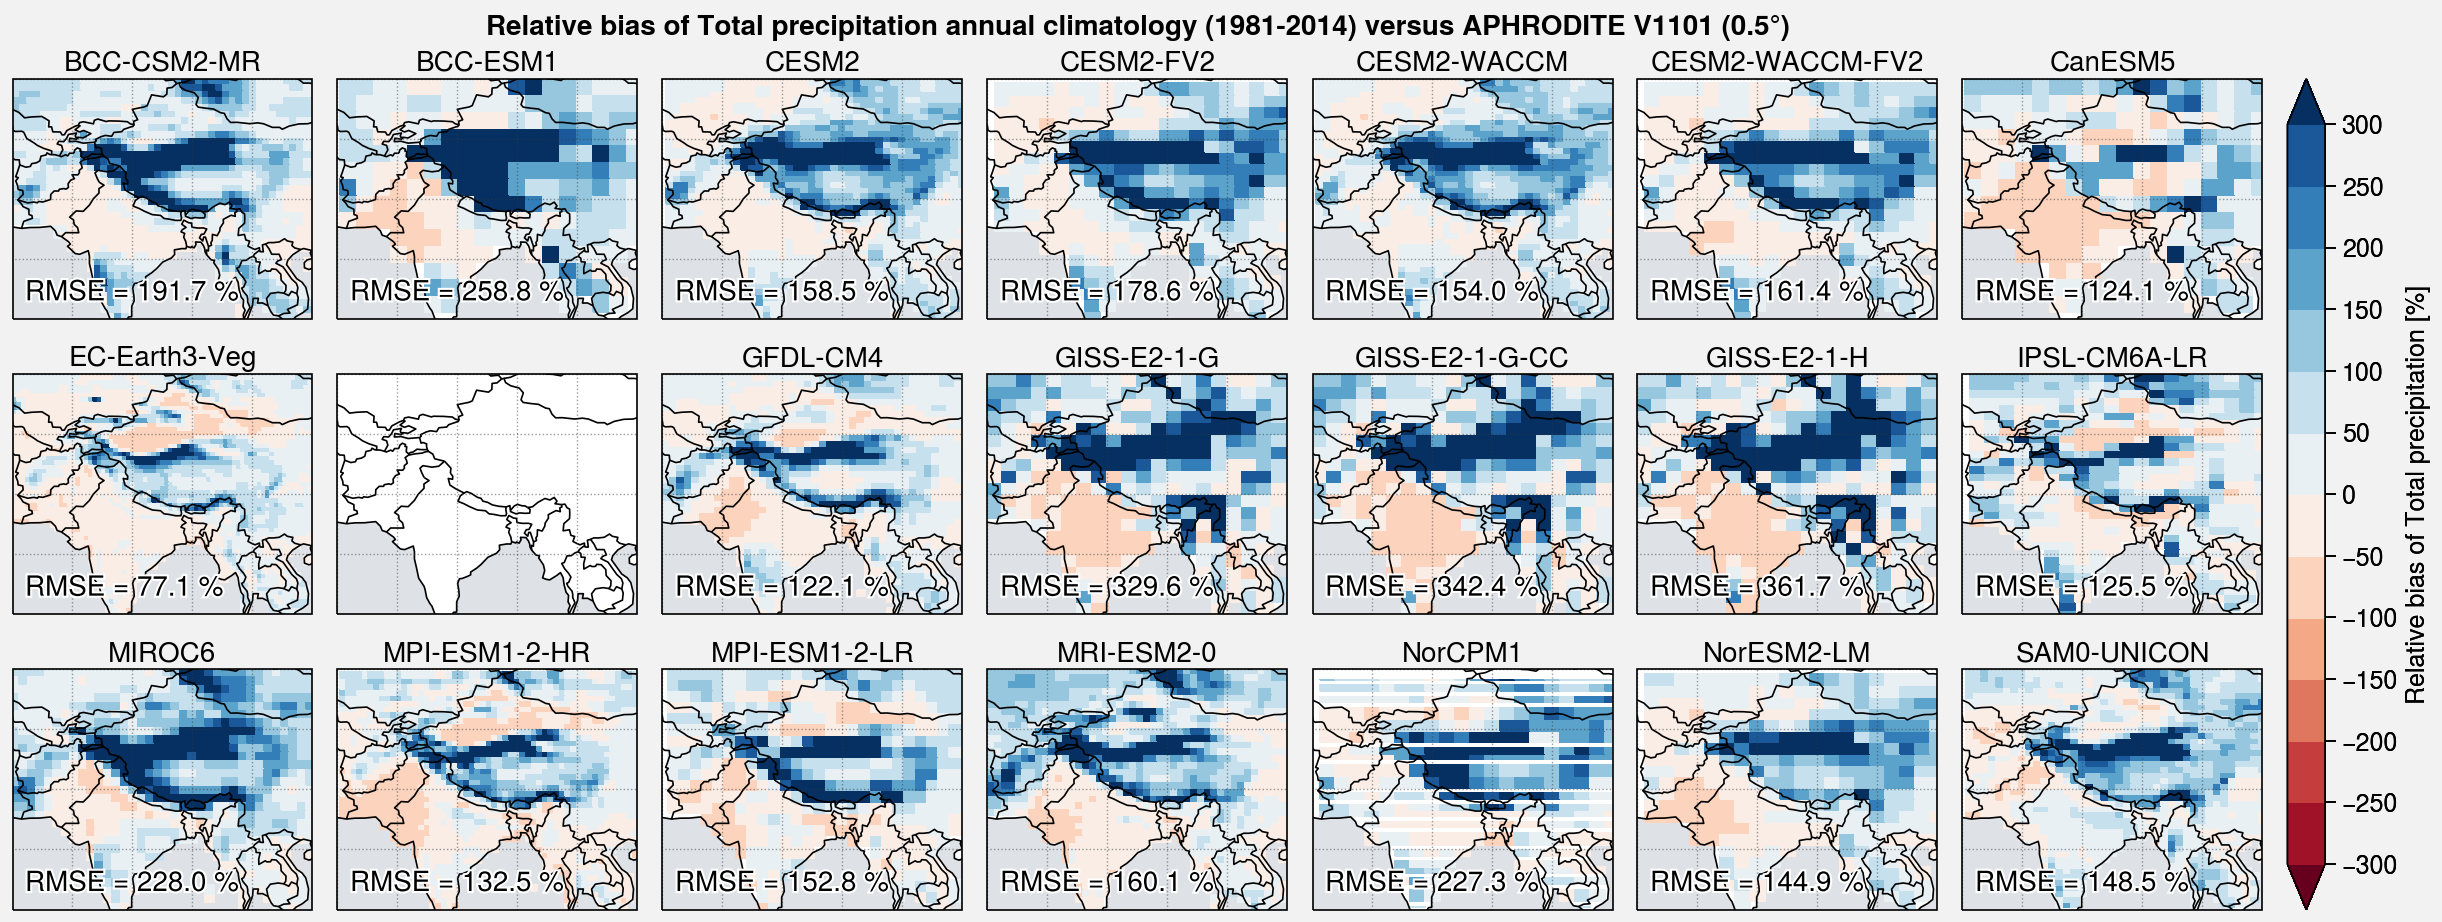

In [68]:
cmap_bias = 'RdBu'
levels_bias = plot.arange(-300,300,50)
extend_bias = 'both'

f, axs = plot.subplots(proj='cyl', ncols=7, nrows=3, axwidth=1.5)

for i, ax in enumerate(axs):
    if not list_models[i] == 'ACCESS-ESM1-5':
        #Plot
        m = axs[i].pcolormesh(bias_relative[i].sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])), cmap=cmap_bias, levels=levels_bias, extend=extend_bias)

        # Compute RMSE
        rmse = np.sqrt((bias_relative[i].sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1]))**2).mean().values)

        axs[i].format(
            title=list_models[i],
            lltitle='RMSE = '+str(round(rmse,1)) +' %'
        )
    
    
f.colorbar(m, label='Relative bias of ' + label + ' [%]', loc='r')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=False, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Relative bias of "+label+" annual climatology ("+period.start+"-"+period.stop+") versus "+obs_longname,
    lonlines=10, latlines=10, abc=False, latlim=latlim, lonlim=lonlim
)

f.save('img/'+var+'_bias_relative_multimodel.jpg')